In [4]:
import sys
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import snowflake.connector
import snowflake
import datetime as dt

In [5]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

In [6]:
con = snowflake.connector.connect(
    user="tliang@endpointclosing.com",
    account="endpoint",
    authenticator="externalbrowser",
    role="SNOWFLAKE_DATA_ENGINEERING",
    warehouse="DATAENGINEERING_WH"
)
cur = con.cursor()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [7]:
query = "SELECT * FROM LAKE.SALESFORCE.LEAD WHERE IS_DELETED = 'FALSE'"
all_lead = cur.execute(query).fetch_pandas_all().reset_index()

In [8]:
query = "SELECT * FROM LAKE.SALESFORCE.TASK"
all_task = cur.execute(query).fetch_pandas_all().reset_index()

In [9]:
all_task.shape

(430072, 111)

In [10]:
# query = "SELECT * FROM LAKE.SALESFORCE.TASK WHERE WHO_ID IN (SELECT CONVERTED_CONTACT_ID FROM LAKE.SALESFORCE.LEAD WHERE IS_DELETED = 'FALSE')"
# all_task_converted = cur.execute(query).fetch_pandas_all().reset_index()

In [11]:
# all_task_converted.shape

In [12]:
query = "SELECT * FROM LAKE.SALESFORCE.LEAD_HISTORY"
all_lead_hist = cur.execute(query).fetch_pandas_all().reset_index()

In [13]:
all_lead.columns.to_list()

['index',
 'ID',
 'IS_DELETED',
 'MASTER_RECORD_ID',
 'LAST_NAME',
 'FIRST_NAME',
 'SALUTATION',
 'MIDDLE_NAME',
 'SUFFIX',
 'NAME',
 'RECORD_TYPE_ID',
 'TITLE',
 'COMPANY',
 'STREET',
 'CITY',
 'STATE',
 'POSTAL_CODE',
 'COUNTRY',
 'LATITUDE',
 'LONGITUDE',
 'GEOCODE_ACCURACY',
 'PHONE',
 'MOBILE_PHONE',
 'FAX',
 'EMAIL',
 'WEBSITE',
 'PHOTO_URL',
 'DESCRIPTION',
 'LEAD_SOURCE',
 'STATUS',
 'INDUSTRY',
 'RATING',
 'ANNUAL_REVENUE',
 'NUMBER_OF_EMPLOYEES',
 'OWNER_ID',
 'HAS_OPTED_OUT_OF_EMAIL',
 'IS_CONVERTED',
 'CONVERTED_DATE',
 'CONVERTED_ACCOUNT_ID',
 'CONVERTED_CONTACT_ID',
 'CONVERTED_OPPORTUNITY_ID',
 'IS_UNREAD_BY_OWNER',
 'CREATED_DATE',
 'CREATED_BY_ID',
 'LAST_MODIFIED_DATE',
 'LAST_MODIFIED_BY_ID',
 'SYSTEM_MODSTAMP',
 'LAST_ACTIVITY_DATE',
 'DO_NOT_CALL',
 'HAS_OPTED_OUT_OF_FAX',
 'LAST_VIEWED_DATE',
 'LAST_REFERENCED_DATE',
 'LAST_TRANSFER_DATE',
 'JIGSAW',
 'JIGSAW_CONTACT_ID',
 'EMAIL_BOUNCED_REASON',
 'EMAIL_BOUNCED_DATE',
 'INDIVIDUAL_ID',
 'POSTAL_CODE_C',
 'MOST_RE

In [14]:
# decide which contact to use 
# successful phone call
# success contact recently

In [15]:
# how accurate the reteived results are compared to the lead contacts

In [16]:
all_lead.shape

(625302, 162)

In [17]:
# Type 1: has contact (email or call) in the past 30 days

In [18]:
cutoff_date_end = dt.date(2022,5,19)
cutoff_date_start = dt.date(2022,5,19) - dt.timedelta(days = 30)

In [19]:
rec_month_all_task = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start) & (all_task["ACTIVITY_DATE"] < cutoff_date_end) & (all_task["TASK_SUBTYPE"].isin(["Call","Email"]))]

In [20]:
rec_month_all_task.shape

(14993, 111)

In [21]:
all_lead["RECENT_CONTACT"]  = np.where(all_lead["ID"].isin(rec_month_all_task["WHO_ID"]),True, False)

In [22]:
 all_lead["RECENT_CONTACT"].value_counts()

False    621155
True       4147
Name: RECENT_CONTACT, dtype: int64

In [23]:
all_lead["RECENT_CONTACT"].value_counts() / len(all_lead)

False    0.993368
True     0.006632
Name: RECENT_CONTACT, dtype: float64

In [24]:
all_lead.groupby("RECENT_CONTACT")["IS_CONVERTED"].value_counts()

RECENT_CONTACT  IS_CONVERTED
False           False           611395
                True              9760
True            False             4146
                True                 1
Name: IS_CONVERTED, dtype: int64

In [25]:
all_lead.groupby("RECENT_CONTACT").apply(lambda x: x.isna().sum()/ len(x))

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT
RECENT_CONTACT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.0,0.0,0.0,1.0,0.0,0.000364,0.998918,0.686651,0.999994,0.0,0.001120,0.999013,0.251684,0.010633,0.030958,0.007792,0.031786,0.999816,0.999874,0.999874,1.0,0.267202,0.286107,1.0,0.153395,0.983346,0.0,1.0,0.398786,0.0,1.0,0.999757,1.0,0.999874,0.0,0.0,0.0,0.984287,0.984664,0.984510,0.989257,0.0,0.0,0.0,0.0,0.0,0.0,0.952757,0.0,0.0,0.999572,0.999572,0.0,1.0,1.0,0.999496,0.999496,1.0,1.0,0.972033,0.998971,0.0,0.0,0.994521,0.996627,0.991827,0.0,0.999198,0.0,0.961876,0.999559,0.999569,0.963107,0.999699,0.049002,0.896971,0.903166,0.984938,0.995512,0.991862,0.994953,0.993015,0.996424,0.801620,0.999870,0.998529,0.999911,0.013085,0.999668,0.988480,0.748641,0.999498,0.810603,0.185712,0.0,0.903140,0.98449,0.999565,0.0,0.830334,1.0,0.999586,1.0,0.999998,0.999998,0.999998,0.999588,0.999911,1.0,0.999989,0.999984,1.0,0.999915,0.999998,0.830334,0.999581,0.999588,1.0,1.0,1.0,1.0,1.0,0.853632,0.999998,0.805826,1.0,0.832956,0.987296,0.999874,0.999868,0.013552,0.978397,0.797044,0.999874,0.803559,0.999874,0.999998,0.999945,0.998416,0.999870,0.0,0.

In [26]:
# print("call+email",all_lead[(all_lead["RECENT_CONTACT"] == True)&(all_lead["MOBILE_PHONE"].notna() == True)&(all_lead["EMAIL"].notna() == True)].shape[0])
# print("call only",all_lead[(all_lead["RECENT_CONTACT"] == True)&(all_lead["MOBILE_PHONE"].notna() == True)&(all_lead["EMAIL"].notna() == True)].shape[0])

In [27]:
id_cutoff_call_only = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start) & (all_task["ACTIVITY_DATE"] < cutoff_date_end) & (all_task["TASK_SUBTYPE"] == "Call")]["WHO_ID"]
id_cutoff_email_only = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start) & (all_task["ACTIVITY_DATE"] < cutoff_date_end) & (all_task["TASK_SUBTYPE"] == "Email")]["WHO_ID"]


In [28]:
print("call+email",all_lead[(all_lead["ID"].isin(id_cutoff_call_only))& (all_lead["ID"].isin(id_cutoff_email_only))].shape[0])
print("call only",all_lead[(all_lead["ID"].isin(id_cutoff_call_only))& (~all_lead["ID"].isin(id_cutoff_email_only))].shape[0])
print("email only",all_lead[(~all_lead["ID"].isin(id_cutoff_call_only))& (all_lead["ID"].isin(id_cutoff_email_only))].shape[0])

call+email 1116
call only 1305
email only 1726


In [29]:
# Type 2: has MLS ID

In [30]:
print("Proportion of lead who have MLS ID is", round(all_lead["AGENT_MLS_ID_C"].notna().sum()/len(all_lead),2),all_lead["AGENT_MLS_ID_C"].notna().sum())

Proportion of lead who have MLS ID is 0.25 158861


In [31]:
# Type 3: has mobile phone

In [32]:
print("Proportion of lead who have mobile phone is", round(all_lead["MOBILE_PHONE"].notna().sum()/len(all_lead),2),all_lead["MOBILE_PHONE"].notna().sum())

Proportion of lead who have mobile phone is 0.72 447333


In [33]:
# wrap it all

In [34]:
print("Number of leads who have MLSID and mobile phone is",len(all_lead[(all_lead["AGENT_MLS_ID_C"].notna() == True) & (all_lead["MOBILE_PHONE"].notna() == True)]))
print("Number of leads who have MLSID but no mobile phone is",len(all_lead[(all_lead["AGENT_MLS_ID_C"].notna() == True) & (all_lead["MOBILE_PHONE"].isna() == True)]))
print("Number of leads who don't have MLSID but have mobile phone is",len(all_lead[(all_lead["AGENT_MLS_ID_C"].isna() == True) & (all_lead["MOBILE_PHONE"].notna() == True)]))

Number of leads who have MLSID and mobile phone is 114213
Number of leads who have MLSID but no mobile phone is 44648
Number of leads who don't have MLSID but have mobile phone is 333120


In [35]:
# sanity check

In [36]:
# recent converted id, check 
recent_id = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start) & (all_task["ACTIVITY_DATE"] < cutoff_date_end)]["WHO_ID"]
all_lead[(all_lead["ID"].isin(recent_id))&(all_lead["IS_CONVERTED"] == True)]

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT
203246,35079,00Q1H00001GSt1DUAT,False,None,Way,Connie,None,Diane,None,Connie Diane Way,0121H000000zyGvQAI,None,HOMESMART SUCCESS,PO Box 1464,MARICOPA,AZ,85139,None,NaN,NaN,None,(520) 350-1474,(503) 668-5254,None,sisters@yourpropertysisters.com,None,/services/images/photo/00Q1H00001GSt1DUAT,None,Cold Account Creation,Committed,None,None,NaN,NaN,0058V00000C7zkjQAB,False,True,2022-05-06,0011H00002AJl7VQAT,0038V00002W3peFQAR,0068V00000rkDffQAE,False,2020-10-01 18:12:03-07:00,0051H000008rwTGQAY,2022-05-06 22:11:21-07:00,0051H00000BQg3LQAT,2022-05-06 22:11:21-07:00,2022-05-06,False,False,NaT,NaT,2022-04-14,None,None,None,NaT,None,None,None,None,False,False,None,NaN,NaN,False,None,True,247467.0,None,NaN,2022-05-06,None,0011H00002AJl7VQAT,5.0,Pinal,New Lead / Cold Outreach,None,1.0,None,None,NaN,3.0,NaN,None,None,Agent,None,None,2.02E+24,None,Level 3 - Less than 4 listings/yr,SA674523000,False,Salesperson,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,None,None,239433.0,NaN,2.0,None,NaN,NaN,277713,None,None,NaN,365212,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2022-05-06 23:40:58.524000-07:00,False,None,None,None,False,Fal

In [37]:
all_lead.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT
0,0,00Q8V00001NZmdBUAT,False,None,Ault,Harrison,None,None,None,Harrison Ault,0121H000000zyGvQAI,None,None,7373 North Scottsdale Road Suite A100,Scottsdale,AZ,85253,None,NaN,NaN,None,(480)327-6700,None,None,harrison@trurealty.com,None,/services/images/photo/00Q8V00001NZmdBUAT,None,Industry Referral,Committed,None,None,NaN,NaN,0051H00000BeZYAQA3,False,True,2022-04-21,0011H00002AJuhHQAT,0038V00002VbTgJQAV,0068V00000rijz8QAA,False,2022-04-21 07:22:03-07:00,0051H00000BeZYAQA3,2022-04-21 07:22:30-07:00,0051H00000BeZYAQA3,2022-04-21 07:22:30-07:00,None,False,False,NaT,NaT,2022-04-21,None,None,None,NaT,None,None,None,None,False,False,None,NaN,NaN,False,None,True,NaN,None,NaN,None,None,0011H00002AJuhHQAT,0.0,None,None,None,NaN,None,None,NaN,NaN,NaN,None,None,Agent,None,None,None,None,Level 3 - Less than 4 listings/yr,SA702016000,False,None,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,888727,None,None,NaN,None,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2022-04-21 07:41:01.252000-07:00,False,None,None,None,False,False,False,None,None,NaT,None,None,None,None,False
1,1,00Q8V00001M91QWUAZ,Fal

In [38]:
all_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
0,0,00T1H00003sNlipUAC,0031H00002MfqU4QAJ,0061H00000nX0V6QAK,1,1,Called LM,2019-11-13,Completed,Normal,False,0051H000009T3lOQAS,None,None,False,0011H00001csXeBQAU,True,2019-11-13 15:23:27-08:00,0051H000009T3lOQAS,2020-09-14 09:47:09-07:00,0051H000008sMEFQA2,2020-11-15 05:31:53-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2019-11-13 15:23:27-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:07:41.617000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
1,1,00T1H00004fcZMUUA2,00Q1H00001GSXxKUAX,0XB1H000000Xe9pWAC,1,1,List Email: Do You Not Want To SAVE Your Buyer...,2021-08-27,Completed,Normal,False,0051H00000BellzQAB,None,None,False,None,True,2021-08-27 10:15:00-07:00,0051H00000BellzQAB,2021-08-27 10:15:01-07:00,0051H00000BellzQAB,2021-08-27 10:15:01-07:00,0.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,ListEmail,2021-08-27 10:15:00-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:41.861000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
2,2,00T8V00004kiISPUA2,00Q1H00001GSYr3UAH,Non

In [39]:
all_task[all_task["WHO_COUNT"]>1]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
43469,5099,00T8V00004qob7wUAA,0031H00002Ss2OFQAZ,None,2,0,Email: Re: Question for Title Officer - 1013 W...,2022-03-02,Completed,Normal,False,0051H00000BenXkQAJ,To: sandydunkley@gmail.com\nCC: dkaplan@endpoi...,None,False,0011H0000230xaEQAQ,True,2022-03-02 16:04:16-08:00,0051H00000BenXkQAJ,2022-03-02 16:04:16-08:00,0051H00000BenXkQAJ,2022-03-02 16:04:16-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2022-03-02 16:04:16-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-03-02 18:41:00.506000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
59933,21563,00T8V00004rM5H8UAK,0038V00002TMGOyQAP,None,2,0,Email: Re: [Endpoint] Re: RE: [Endpoint] Re: R...,2022-03-11,Completed,Normal,False,0051H00000BenXkQAJ,To: monica@greatergoodrealty.com\nCC: closing....,None,False,0011H0000230y3YQAQ,True,2022-03-11 11:25:26-08:00,0051H00000BenXkQAJ,2022-03-11 11:25:26-08:00,0051H00000BenXkQAJ,2022-03-11 11:25:26-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2022-03-11 11:25:26-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-03-11 12:41:13.365000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,N

In [40]:
# WHO_ID is displayed as one ID only, no matter how many WHO_COUNT is 
all_task[all_task["WHO_ID"].isin([i for i in all_task["WHO_ID"].fillna("") if len(i) > 18])]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C


In [41]:
all_lead[(all_lead["ID"].isin(recent_id))].shape

(5342, 163)

In [42]:
all_lead[((all_lead["ID"].isin(recent_id))|all_lead["CONVERTED_CONTACT_ID"].isin(recent_id))&(all_lead["IS_CONVERTED"] == True)]

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT
397,260,00Q1H00001KEYWRUA5,False,None,Test,Point,None,None,None,Point Test,0121H000000zyGvQAI,None,test.com,2 Street,Seattle,WA,12345,None,NaN,NaN,None,(206) 555-8585,(123) 945-6789,None,rogerpoint@test.com,None,/services/images/photo/00Q1H00001KEYWRUA5,None,Site Signup,Committed,None,None,NaN,NaN,00G1H000004ldrdUAA,False,True,2022-02-28,0011H00001TAT3HQAX,None,None,False,2021-05-11 13:53:32-07:00,0051H000008rwTGQAY,2022-02-28 21:08:58-08:00,0051H00000BQg3LQAT,2022-03-20 12:31:24-07:00,None,False,False,NaT,NaT,2022-02-28,None,None,None,NaT,None,None,7018V000000HE5eQAG,None,True,False,None,NaN,NaN,False,None,True,NaN,None,NaN,None,None,0011H00001TAT3HQAX,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,None,None,Agent,None,None,None,None,None,None,False,None,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,2021-05-11,None,NaN,NaN,NaN,None,NaN,NaN,486365,None,None,NaN,None,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2022-03-20 13:40:51.518000-07:00,False,None,None,None,False,False,False,11239456789,None,NaT,None,None,None,None,False
398,261,00Q8V00001M8WRJUA3,False,None,Test,Ella,None,None,None,Ella Test,0121H000000zyGvQAI,

In [43]:
# # CONTACT CONVETRED ID IS NOT SHOWN IN WHO_ID
# all_task_converted[all_task_converted["WHO_ID"].isin(recent_id)]

In [44]:
recent_task_type_count = all_task[all_task["WHO_ID"].isin(recent_id)].groupby("WHO_ID")["TASK_SUBTYPE"].value_counts().unstack().fillna(0)
recent_task_type_count.describe()

TASK_SUBTYPE,Call,Email,ListEmail,Task
count,7686.000000,7686.000000,7686.000000,7686.000000
mean,3.624772,7.209862,0.538381,2.770492
std,5.421059,31.782386,1.410536,5.079884
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,2.000000,3.000000,0.000000,1.000000
75%,4.000000,6.000000,0.000000,3.000000
max,48.000000,1604.000000,13.000000,41.000000


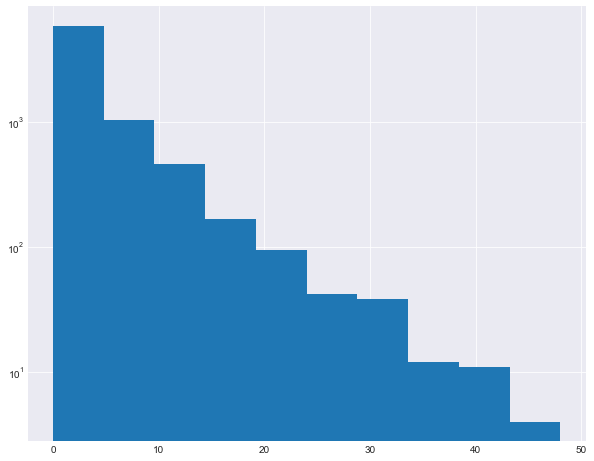

In [45]:
recent_task_type_count["Call"].hist()
plt.yscale("log")
plt.show()

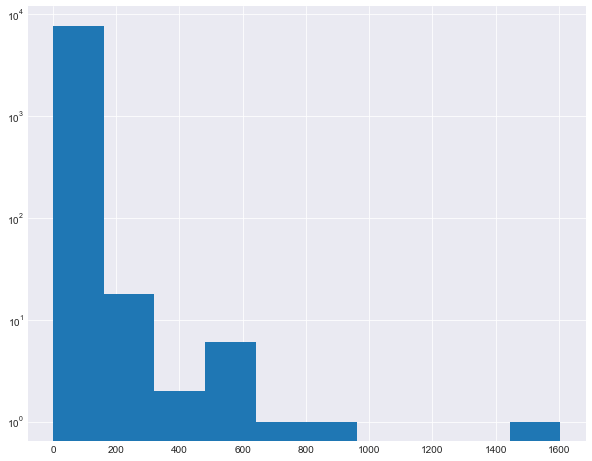

In [46]:
recent_task_type_count["Email"].hist()
plt.yscale("log")
plt.show()

In [47]:
all_task["WHO_ID"].value_counts()

0031H00002O2x8dQAB    1624
0031H00002SaUI1QAN    1224
00Q1H00001KcNswUAF     887
0031H00002Qg8fuQAB     646
0031H00002Sb7kKQAR     635
                      ... 
00Q1H00001GSszcUAD       1
0038V00002VcFHtQAN       1
0038V00002VMDCTQA5       1
00Q1H00001GSjhCUAT       1
00Q1H00001CojS4UAJ       1
Name: WHO_ID, Length: 42876, dtype: int64

In [48]:
all_task[all_task["WHO_ID"] == "00Q1H00001KcNswUAF"]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
197,151,00T1H00004fbWXYUA2,00Q1H00001KcNswUAF,None,1,0,Sent (Reply): Re: End of Day Report 08/24,2021-08-24,Completed,Normal,False,0051H00000BeZYAQA3,To: theresawalde@cyberbacker.com\nCc: kurtleri...,Email,False,None,True,2021-08-24 16:00:51-07:00,0051H00000BeZYAQA3,2021-08-24 16:00:51-07:00,0051H00000BeZYAQA3,2021-08-24 16:00:51-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-08-24 16:00:51-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:38.543000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
711,256,00T1H00004fZcVqUAK,00Q1H00001KcNswUAF,None,1,0,Replied: Re: Teresa Scott-Tibbs (Knock),2021-08-18,Completed,Normal,False,0051H00000BeZYAQA3,To: tiffany@endpointclosing.com\nCc: \nBcc: \n...,Email,False,None,True,2021-08-18 11:30:36-07:00,0051H00000BeZYAQA3,2021-08-18 11:30:36-07:00,0051H00000BeZYAQA3,2021-08-18 11:30:36-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-08-18 11:30:36-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:34.276000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,No

In [49]:
all_lead[all_lead["ID"] == "00Q1H00001KcNswUAF"]

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT
295146,2091,00Q1H00001KcNswUAF,False,None,Anne walde,Theresa,None,None,None,Theresa Anne walde,0121H000000zyGvQAI,None,None,1622 W INA RD,TUCSON,AZ,85704,None,NaN,NaN,None,(520) 877-2656,None,None,theresawalde@cyberbacker.com,None,/services/images/photo/00Q1H00001KcNswUAF,None,Industry Referral,Working,None,None,NaN,NaN,0051H00000BeZYAQA3,False,False,None,None,None,None,False,2021-06-17 11:19:03-07:00,0051H00000BeZYAQA3,2022-05-27 15:46:14-07:00,0051H00000BeZYAQA3,2022-05-27 15:46:14-07:00,2022-05-27,False,False,2022-04-01 19:31:11-07:00,2022-04-01 19:31:11-07:00,2021-06-17,None,None,None,NaT,None,None,7018V000000HFNsQAO,None,False,False,None,NaN,NaN,False,None,True,NaN,None,NaN,2021-06-17,None,0011H00002AJmPfQAL,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,None,None,Agent,None,None,None,None,Level 3 - Less than 4 listings/yr,None,False,None,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,2021-11-29,None,NaN,NaN,NaN,None,NaN,NaN,486850,None,None,NaN,None,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2022-05-27 17:40:55.178000-07:00,True,None,None,None,False,False,False,None,None,NaT,False,False,None,None,True


In [50]:
# converted id check

In [51]:
converted_id = all_lead[all_lead["IS_CONVERTED"] == True]["ID"]
converted_contact_id = all_lead[all_lead["IS_CONVERTED"] == True]["CONVERTED_CONTACT_ID"]


In [52]:
all_task["WHO_ID"].nunique()

42876

In [53]:
all_task[all_task["WHO_ID"].isin(converted_id)]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
2398,195,00T1H00004PIxuqUAD,00Q1H00001JeNFCUA3,None,1,0,Opened: Re: Buyer and TC info,2021-03-01,Completed,Normal,False,0051H000009T3lOQAS,To: yourfasttc@gmail.com\nCc: renickbabayan@gm...,#N/A,False,None,True,2021-03-01 16:41:01-08:00,0051H000009T3lOQAS,2021-03-01 16:41:01-08:00,0051H000009T3lOQAS,2022-03-06 05:06:14-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-03-01 16:41:01-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-03-06 06:41:41.885000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
6474,1420,00T1H00004PIxwwUAD,00Q1H00001JeNFCUA3,None,1,0,Replied: Re: Buyer and TC info,2021-03-01,Completed,Normal,False,0051H000009T3lOQAS,To: daniel@endpointclosing.com\nCc: renickbaba...,Email,False,None,True,2021-03-01 16:42:31-08:00,0051H000009T3lOQAS,2021-03-01 16:42:31-08:00,0051H000009T3lOQAS,2022-03-06 05:06:14-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-03-01 16:42:30-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-03-06 06:41:41.884000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,Na

In [54]:
# only 114 task records for converted leads
all_task[all_task["WHO_ID"].isin(converted_id)].shape

(114, 111)

In [55]:
all_task[all_task["WHO_ID"].isin(converted_contact_id)]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
0,0,00T1H00003sNlipUAC,0031H00002MfqU4QAJ,0061H00000nX0V6QAK,1,1,Called LM,2019-11-13,Completed,Normal,False,0051H000009T3lOQAS,None,None,False,0011H00001csXeBQAU,True,2019-11-13 15:23:27-08:00,0051H000009T3lOQAS,2020-09-14 09:47:09-07:00,0051H000008sMEFQA2,2020-11-15 05:31:53-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2019-11-13 15:23:27-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:07:41.617000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
7,7,00T8V00004kiIM5UAM,0031H00002SsA2tQAF,0061H00000q0wKAQAY,1,1,"Replied: Fwd: 109408AZ: 3928 E Encanto Street,...",2021-10-16,Completed,Normal,False,0051H00000BeZYAQA3,To: tiffany@endpointclosing.com\nCc: \nBcc: \n...,Email,False,0011H00002AJkcBQAT,True,2021-10-16 15:14:30-07:00,0051H00000BeZYAQA3,2021-10-16 15:14:30-07:00,0051H00000BeZYAQA3,2021-10-16 15:14:30-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-10-16 15:14:30-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-10-16 19:44:37.344000-07:00,None,None,False,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,N

In [56]:
all_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
0,0,00T1H00003sNlipUAC,0031H00002MfqU4QAJ,0061H00000nX0V6QAK,1,1,Called LM,2019-11-13,Completed,Normal,False,0051H000009T3lOQAS,None,None,False,0011H00001csXeBQAU,True,2019-11-13 15:23:27-08:00,0051H000009T3lOQAS,2020-09-14 09:47:09-07:00,0051H000008sMEFQA2,2020-11-15 05:31:53-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2019-11-13 15:23:27-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:07:41.617000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
1,1,00T1H00004fcZMUUA2,00Q1H00001GSXxKUAX,0XB1H000000Xe9pWAC,1,1,List Email: Do You Not Want To SAVE Your Buyer...,2021-08-27,Completed,Normal,False,0051H00000BellzQAB,None,None,False,None,True,2021-08-27 10:15:00-07:00,0051H00000BellzQAB,2021-08-27 10:15:01-07:00,0051H00000BellzQAB,2021-08-27 10:15:01-07:00,0.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,ListEmail,2021-08-27 10:15:00-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:41.861000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
2,2,00T8V00004kiISPUA2,00Q1H00001GSYr3UAH,Non

In [57]:
converted_task_type_count = all_task[all_task["WHO_ID"].isin(converted_id)].groupby("WHO_ID")["TASK_SUBTYPE"].value_counts().unstack().fillna(0)
converted_task_type_count.describe()

TASK_SUBTYPE,Call,Email
count,75.000000,75.000000
mean,0.133333,1.386667
std,0.342224,1.261631
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,1.000000,8.000000


In [58]:
## recent contact id with task

In [59]:
## expand the cutoff date

In [60]:
cutoff_date_end2 = dt.date(2022,5,19)
cutoff_date_start2 = cutoff_date_end2 - dt.timedelta(days = 90)
rec_quarter_all_task = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start2) & (all_task["ACTIVITY_DATE"] < cutoff_date_end2) & (all_task["TASK_SUBTYPE"].isin(["Call","Email"]))]


In [61]:
rec_quarter_all_task.shape

(38336, 111)

In [62]:
all_lead["RECENT_CONTACT_QUARTER"]  = np.where(all_lead["ID"].isin(rec_quarter_all_task["WHO_ID"]),True, False)
print("Number:\n",all_lead["RECENT_CONTACT_QUARTER"].value_counts())
print("Perc:\n",all_lead["RECENT_CONTACT_QUARTER"].value_counts() / len(all_lead))

Number:
 False    617100
True       8202
Name: RECENT_CONTACT_QUARTER, dtype: int64
Perc:
 False    0.986883
True     0.013117
Name: RECENT_CONTACT_QUARTER, dtype: float64


In [63]:
print(all_lead.groupby("RECENT_CONTACT_QUARTER")["IS_CONVERTED"].value_counts())

RECENT_CONTACT_QUARTER  IS_CONVERTED
False                   False           607344
                        True              9756
True                    False             8197
                        True                 5
Name: IS_CONVERTED, dtype: int64


In [64]:
id_cutoff_call_only_quarter = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start2) & (all_task["ACTIVITY_DATE"] < cutoff_date_end2) & (all_task["TASK_SUBTYPE"] == "Call")]["WHO_ID"]
id_cutoff_email_only_quarter = all_task[(all_task["ACTIVITY_DATE"] >= cutoff_date_start2) & (all_task["ACTIVITY_DATE"] < cutoff_date_end2) & (all_task["TASK_SUBTYPE"] == "Email")]["WHO_ID"]
print("call + email:",all_lead[(all_lead["ID"].isin(id_cutoff_call_only_quarter))& (all_lead["ID"].isin(id_cutoff_email_only_quarter))].shape[0])
print("call only:",all_lead[(all_lead["ID"].isin(id_cutoff_call_only_quarter))& (~all_lead["ID"].isin(id_cutoff_email_only_quarter))].shape[0])
print("email only:",all_lead[(~all_lead["ID"].isin(id_cutoff_call_only_quarter))& (all_lead["ID"].isin(id_cutoff_email_only_quarter))].shape[0])

call + email: 2543
call only: 2849
email only: 2810


In [65]:
# contact datasets

In [66]:
query = "SELECT * FROM LAKE.SALESFORCE.CONTACT WHERE IS_DELETED = 'FALSE'"
all_contact = cur.execute(query).fetch_pandas_all().reset_index()

In [67]:
all_contact.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C
0,0,0038V00002W81YBQAZ,False,None,0011H00002FRq9iQAD,False,Britton,Niki,None,None,None,Niki Britton,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,19103 Interstate 45 N,Spring,TX,77388,None,NaN,NaN,None,(832) 652-7589,None,(281) 570-8080,None,None,None,None,nikib@fullcirclehtx.com,None,None,None,Transferred Client,None,None,0058V00000C7yuxQAB,False,False,False,2022-05-31 09:01:57-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,2022-04-27,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0038V00002W81YBQAZ,None,None,None,NaN,Committed,None,None,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,First Order,None,None,None,NaN,False,2022-03-14,None,None,None,None,NaN,None,None,False,None,None,None,1.0,None

In [68]:
all_contact["RECENT_CONTACT"]  = np.where(all_contact["ID"].isin(rec_month_all_task["WHO_ID"]),True, False)
all_contact["RECENT_CONTACT_QUARTER"]  = np.where(all_contact["ID"].isin(rec_quarter_all_task["WHO_ID"]),True, False)

In [69]:
print("RECENT_CONTACT: \n", all_contact["RECENT_CONTACT"].value_counts())
print("RECENT_CONTACT_QUARTER: \n", all_contact["RECENT_CONTACT_QUARTER"].value_counts())


RECENT_CONTACT: 
 False    8672
True     1994
Name: RECENT_CONTACT, dtype: int64
RECENT_CONTACT_QUARTER: 
 False    6948
True     3718
Name: RECENT_CONTACT_QUARTER, dtype: int64


In [70]:
all_contact[all_contact["ID"].isin(rec_month_all_task["WHO_ID"])].head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER
0,0,0038V00002W81YBQAZ,False,None,0011H00002FRq9iQAD,False,Britton,Niki,None,None,None,Niki Britton,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,19103 Interstate 45 N,Spring,TX,77388,None,NaN,NaN,None,(832) 652-7589,None,(281) 570-8080,None,None,None,None,nikib@fullcirclehtx.com,None,None,None,Transferred Client,None,None,0058V00000C7yuxQAB,False,False,False,2022-05-31 09:01:57-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,2022-04-27,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0038V00002W81YBQAZ,None,None,None,NaN,Committed,None,None,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,First Order,None,None,None,NaN,False,2022-03-14,None,None,None,None,NaN,N

In [71]:
rec_month_all_task.shape

(14993, 111)

In [72]:
all_contact.sample(n = 5, random_state=1)

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER
6872,1734,0031H00002O4QllQAF,False,None,0011H00002314n0QAA,False,Grant-shoemaker,Ali,None,None,None,Ali Grant-shoemaker,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,41114 Big Bear Blvd.,Big Bear Lake,CA,92315,None,NaN,NaN,None,909-866-6161,None,(530) 545-2552,None,None,None,None,ali@tylerwoodgroup.com,None,None,None,NDA,None,None,0051H000008rhDMQAY,False,False,False,2020-10-22 12:22:24-07:00,0051H000008rhDMQAY,2022-04-25 01:00:33-07:00,0051H00000BQg3LQAT,2022-04-25 01:00:33-07:00,2021-12-01,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0031H00002O4QllQAF,None,None,None,NaN,Committed,7018V000000HFNxQAO,2020-10-22,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,First Order,None,None,None,NaN,False,2021-06-

In [73]:
# we can found lead related converted contact in task dataset
all_task[all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"])].head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
0,0,00T1H00003sNlipUAC,0031H00002MfqU4QAJ,0061H00000nX0V6QAK,1,1,Called LM,2019-11-13,Completed,Normal,False,0051H000009T3lOQAS,None,None,False,0011H00001csXeBQAU,True,2019-11-13 15:23:27-08:00,0051H000009T3lOQAS,2020-09-14 09:47:09-07:00,0051H000008sMEFQA2,2020-11-15 05:31:53-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2019-11-13 15:23:27-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,NaN,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:07:41.617000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
7,7,00T8V00004kiIM5UAM,0031H00002SsA2tQAF,0061H00000q0wKAQAY,1,1,"Replied: Fwd: 109408AZ: 3928 E Encanto Street,...",2021-10-16,Completed,Normal,False,0051H00000BeZYAQA3,To: tiffany@endpointclosing.com\nCc: \nBcc: \n...,Email,False,0011H00002AJkcBQAT,True,2021-10-16 15:14:30-07:00,0051H00000BeZYAQA3,2021-10-16 15:14:30-07:00,0051H00000BeZYAQA3,2021-10-16 15:14:30-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-10-16 15:14:30-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-10-16 19:44:37.344000-07:00,None,None,False,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,NaN,N

In [74]:
all_task[all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"])].sort_values(by = "CREATED_DATE",ascending = False).head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
118261,219,00T8V00004uu1OdUAI,0038V00002TRVnBQAX,0068V00000qHuWlQAK,1,1,Call: No Answer,2022-05-31,Completed,Normal,False,0058V00000C7yglQAB,None,Call,False,0011H00001csXYuQAM,True,2022-05-31 09:37:35-07:00,0058V00000C7yglQAB,2022-05-31 09:38:36-07:00,0058V00000C7yglQAB,2022-05-31 09:38:36-07:00,6.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2022-05-31 09:37:35-07:00,None,None,No Answer,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-05-31 09:41:09.502000-07:00,None,None,None,None,NaT,None,NaN,2022-05-31 09:37:34-07:00,None,None,NaN,NaN,None,None,False,+13607397216,NaN,False,NaT,None,None,2022-05-31 09:37:28-07:00,None,None,None,False,False,None,None,False,False,None,None,None,NaN,None,None,None
315195,44,00T8V00004uu3c8UAA,0031H00002LOY80QAH,0061H00000kzWU1QAM,1,1,Call: No Answer,2022-05-31,Completed,Normal,False,0058V00000C7yglQAB,None,Call,False,0011H00001csWs4QAE,True,2022-05-31 09:36:04-07:00,0058V00000C7yglQAB,2022-05-31 09:36:09-07:00,0058V00000C7yglQAB,2022-05-31 09:36:09-07:00,2.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2022-05-31 09:36:04-07:00,None,None,No Answer,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-05-31 09:41:09.501000-07:00,None,None,None,None,NaT,None,NaN,2022-05-31 09:35:58-07:00,None,None,NaN,NaN,None,None,False,+12064845330,NaN,False,NaT,None,None,2022-05-31 09:35:29-07:00,None,Non

In [75]:
all_task[(all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"]))&(all_task["ACTIVITY_DATE"] >= cutoff_date_start)& (all_task["ACTIVITY_DATE"]< cutoff_date_end)]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED,NO_SHOW_CP_C,MEETING_TYPE_CP_C,WORKSPACE_NAME_CP_C,BOOKED_BY_PROSPECT_CP_C,CANCELED_CP_C,QUEUE_NAME_CP_C,BOOKED_BY_C,RESPONSE_STATUS_CP_C,RESCHEDULED_CP_C,MEETING_SERIES_CP_C,ROUTER_NAME_CP_C,DESIGNATED_ASSIGNEE_CP_C
39,39,00T8V00004t918FUAQ,0038V00002VbfwIQAR,0068V00000rirhWQAQ,1,1,Reply: Market Reports,2022-04-23,Completed,Normal,False,0051H00000BeZYAQA3,"Hi Tiffany,\n\nHere is my headshot attached. T...",None,False,0011H00002AJuhHQAT,True,2022-04-23 21:04:28-07:00,0051H00000BeZYAQA3,2022-04-23 21:04:28-07:00,0051H00000BeZYAQA3,2022-04-23 21:04:28-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2022-04-23 21:04:28-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2022-04-23 21:40:56.418000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,False,None,None,None,None,None,None,None,None,NaN,None,None,None
47,1,00T8V00004tk6hyUAA,0038V00002TMDsSQAX,0068V00000qqSfpQAE,1,1,"Email: Re: 8018 Stewart Ave., Westchester, CA ...",2022-05-04,Completed,Normal,False,0051H00000BQifCQAT,https://app.salesloft.com/app/emails/detail/52...,None,False,0018V00002I7dqBQAR,True,2022-05-04 09:06:31-07:00,0051H00000BQifCQAT,2022-05-04 09:12:36-07:00,0051H00000BQifCQAT,2022-05-04 09:12:36-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2022-05-04 09:06:31-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,1.0,NaN,1.0,None,2022-05-04 09:41:14.978000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,<CAMfRxY

In [76]:
all_task[(all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"]))&(all_task["ACTIVITY_DATE"] >= cutoff_date_start)& (all_task["ACTIVITY_DATE"]< cutoff_date_end)]["WHO_ID"].nunique()

2258

In [77]:
# EDA about recent month contacts

In [78]:
recent_month_converted_contacts_id = all_task[(all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"]))&(all_task["ACTIVITY_DATE"] >= cutoff_date_start)& (all_task["ACTIVITY_DATE"]< cutoff_date_end)]["WHO_ID"].unique()
recent_month_converted_contacts_task = all_task[(all_task["WHO_ID"].isin(all_lead["CONVERTED_CONTACT_ID"]))&(all_task["ACTIVITY_DATE"] >= cutoff_date_start)& (all_task["ACTIVITY_DATE"]< cutoff_date_end)]

In [79]:
recent_month_converted_contacts_task_type_count = recent_month_converted_contacts_task.groupby("WHO_ID")["TASK_SUBTYPE"].value_counts().unstack().fillna(0)

In [80]:
recent_month_converted_contacts_task_type_count.describe()

TASK_SUBTYPE,Call,Email,ListEmail,Task
count,2258.000000,2258.000000,2258.000000,2258.000000
mean,0.931798,0.904340,0.003100,0.707706
std,1.534350,1.732605,0.055604,1.101633
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,16.000000,40.000000,1.000000,10.000000


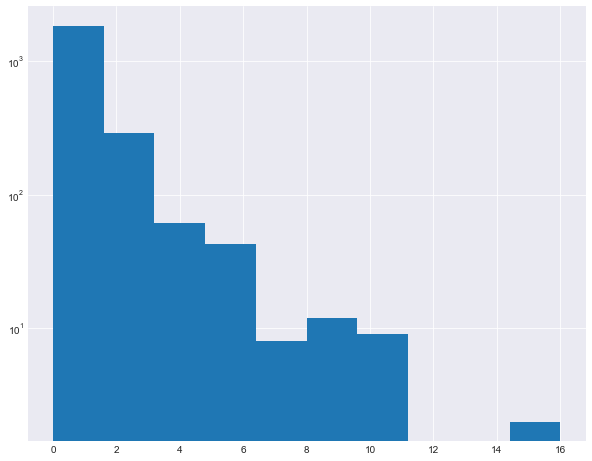

In [81]:
recent_month_converted_contacts_task_type_count["Call"].hist()
plt.yscale("log")
plt.show()

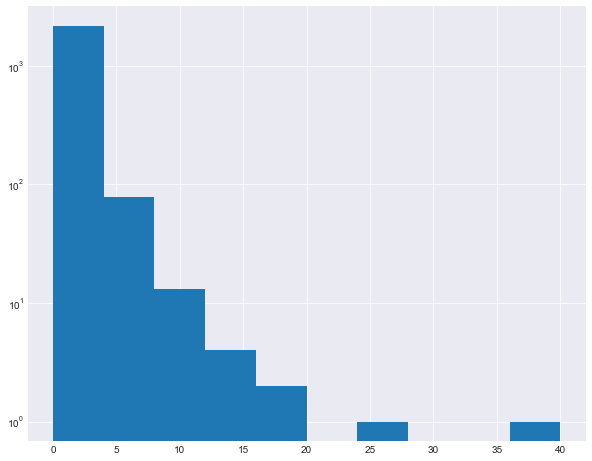

In [82]:
recent_month_converted_contacts_task_type_count["Email"].hist()
plt.yscale("log")
plt.show()

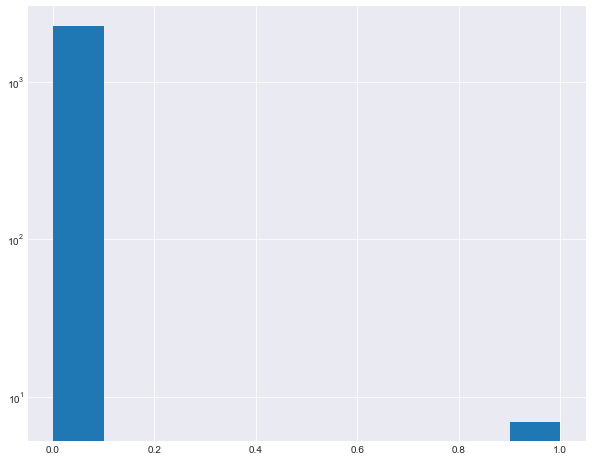

In [83]:
recent_month_converted_contacts_task_type_count["ListEmail"].hist()
plt.yscale("log")
plt.show()

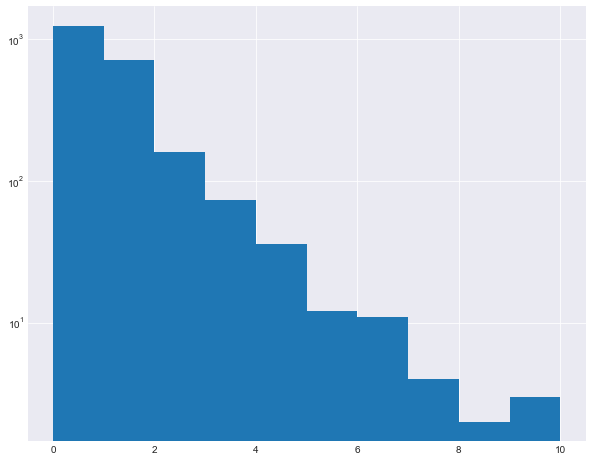

In [84]:
recent_month_converted_contacts_task_type_count["Task"].hist()
plt.yscale("log")
plt.show()

In [85]:
recent_month_converted_contacts = all_contact[all_contact["ID"].isin(recent_month_converted_contacts_id)]
recent_month_converted_contacts["MAILING_STATE_STD"] = ["WA" if i == "Washington" else i for i in recent_month_converted_contacts["MAILING_STATE"] ]

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_3011/2635001896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_month_converted_contacts["MAILING_STATE_STD"] = ["WA" if i == "Washington" else i for i in recent_month_converted_contacts["MAILING_STATE"] ]


In [86]:
recent_month_converted_contacts

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER,MAILING_STATE_STD
0,0,0038V00002W81YBQAZ,False,None,0011H00002FRq9iQAD,False,Britton,Niki,None,None,None,Niki Britton,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,19103 Interstate 45 N,Spring,TX,77388,None,NaN,NaN,None,(832) 652-7589,None,(281) 570-8080,None,None,None,None,nikib@fullcirclehtx.com,None,None,None,Transferred Client,None,None,0058V00000C7yuxQAB,False,False,False,2022-05-31 09:01:57-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,2022-04-27,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0038V00002W81YBQAZ,None,None,None,NaN,Committed,None,None,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,First Order,None,None,None,NaN,False,2022-03-14,None,No

In [87]:
recent_month_converted_contacts.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER,MAILING_STATE_STD
0,0,0038V00002W81YBQAZ,False,None,0011H00002FRq9iQAD,False,Britton,Niki,None,None,None,Niki Britton,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,19103 Interstate 45 N,Spring,TX,77388,None,NaN,NaN,None,(832) 652-7589,None,(281) 570-8080,None,None,None,None,nikib@fullcirclehtx.com,None,None,None,Transferred Client,None,None,0058V00000C7yuxQAB,False,False,False,2022-05-31 09:01:57-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,0058V00000C7vv8QAB,2022-05-31 09:02:04-07:00,2022-04-27,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0038V00002W81YBQAZ,None,None,None,NaN,Committed,None,None,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,First Order,None,None,None,NaN,False,2022-03-14,None,No

In [88]:
recent_month_converted_contacts["MAILING_STATE_STD"].value_counts()

CA    881
WA    733
AZ    343
TX    292
FL      4
CO      2
MD      1
Name: MAILING_STATE_STD, dtype: int64

In [90]:
def sample_contact(df:pd.DataFrame, col:str, max_n_sample:int, random_state = 1) -> pd.DataFrame:
# sample the df based on the number of records by each components

    if df.shape[0] <= max_n_sample:
        return df
    
    else:
        # extract proportion and create list of values which needed to be sampled
        count_series = df[col].value_counts(normalize= True)
        sample_list = count_series[count_series > 0.01].index.to_list()

        # create output dataframe
        output_df = pd.DataFrame()

        # concat those rows which do not need to sample
        output_df = pd.concat([output_df, df[~df[col].isin(sample_list)]])
        # sample the rest with number based on the remaining quota, and concat them
        subset_df = df[df[col].isin(sample_list)].sample(n = max_n_sample - output_df.shape[0], random_state=random_state)
        output_df = pd.concat([output_df,subset_df])

    return output_df

In [91]:
sample_contact = sample_contact(recent_month_converted_contacts,"MAILING_STATE_STD",2000,1)

In [92]:
# sample_contact.to_csv("../data/sample_contact.csv")

In [93]:
sample_contact.reset_index(drop=True)

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER,MAILING_STATE_STD
0,299,0038V00002VO2lDQAT,False,None,0018V00002M8DaCQAV,False,Graves,Monica,None,None,None,Monica Graves,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,9800 Pyramid Court,Englewood,CO,80112,None,NaN,NaN,None,(303) 273-9304,None,3039015224,None,None,None,None,monica@remonica.com,None,None,None,Industry Referral,None,None,0058V00000C7vbXQAR,False,False,False,2022-04-08 12:47:04-07:00,0058V00000C7vbXQAR,2022-05-24 17:31:19-07:00,0058V00000C7vbXQAR,2022-05-24 17:31:19-07:00,2022-05-24,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0038V00002VO2lDQAT,None,None,None,NaN,Committed,None,2022-04-07,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,Demoed,None,None,None,NaN,False,2022-04-08,None,None,N

In [94]:
sample_contact["MAILING_STATE_STD"].value_counts(normalize = True)

CA    0.390390
WA    0.323323
AZ    0.152653
TX    0.130130
FL    0.002002
CO    0.001001
MD    0.000501
Name: MAILING_STATE_STD, dtype: float64

In [116]:
### sample big 4 states, 125 for each state

state_to_sample = ['CA', 'WA', 'AZ', 'TX']


sample_contact_state = (recent_month_converted_contacts[
    (recent_month_converted_contacts["MAILING_STATE_STD"].isin(['CA', 'WA', 'AZ', 'TX']))&
    (~recent_month_converted_contacts[["NAME","EMAIL","PHONE","MOBILE_PHONE","ACCOUNT_ID","MAILING_CITY","MAILING_STATE"]].isnull().any(axis=1))
    ]
    )

four_states_sample_contact = pd.DataFrame()

for state in state_to_sample:
    four_states_sample_contact = pd.concat([four_states_sample_contact,sample_contact_state[sample_contact_state["MAILING_STATE_STD"] == state].sample(n = 125, random_state = 1)])
    

In [118]:
four_states_sample_contact.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER,MAILING_STATE_STD
7021,1883,0031H00002SAPspQAH,False,None,0011H00002317YGQAY,False,Gordon,Paige,None,None,None,Paige Gordon,0121H000000zyGqQAI,None,None,None,None,None,NaN,NaN,None,4149 LIberty Canyon Road,Agoura Hills,CA,91301,None,NaN,NaN,None,(818) 661-4661,None,(805) 750-2105,None,None,None,None,paige.gordon@corcorangroup.com,None,None,None,Transferred Client,None,None,0051H00000BQifCQAT,False,False,False,2021-08-16 15:01:05-07:00,0051H00000BQifCQAT,2022-05-04 10:39:30-07:00,0051H00000BQg3LQAT,2022-05-04 10:39:30-07:00,2022-05-04,NaT,NaT,NaT,NaT,None,NaT,False,/services/images/photo/0031H00002SAPspQAH,None,None,None,NaN,Committed,7018V000000HFNxQAO,2021-08-16,Agent,False,NaN,False,True,None,None,None,None,NaN,NaN,NaN,NaN,Demoed,None,N

In [120]:
four_states_sample_contact["MAILING_STATE_STD"].value_counts()

CA    125
WA    125
AZ    125
TX    125
Name: MAILING_STATE_STD, dtype: int64

In [119]:
four_states_sample_contact[["NAME","EMAIL","PHONE","MOBILE_PHONE","ACCOUNT_ID","MAILING_CITY","MAILING_STATE"]].isna().sum()

NAME             0
EMAIL            0
PHONE            0
MOBILE_PHONE     0
ACCOUNT_ID       0
MAILING_CITY     0
MAILING_STATE    0
dtype: int64

In [121]:
four_states_sample_contact.reset_index(drop = True).to_csv("../data/four_states_sample_contact.csv")

In [100]:
# four_states_sample_contact

In [ ]:
# SF sample contact
